#0. 데이터 개요
2016~2018 년도 급성심정지 환자 개요


In [2]:
# Google Colab을 사용하는 경우 해당 셀을 실행하세요
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap
    

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [118]:
print(list(range(1,5)))

[1, 2, 3, 4]


In [3]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
df18 = pd.read_csv('/content/drive/MyDrive/heart2018.csv',encoding='euc-kr')
df17 = pd.read_csv('/content/drive/MyDrive/heart2017.csv',encoding='euc-kr')
df16 = pd.read_csv('/content/drive/MyDrive/heart2016.csv',encoding='euc-kr')
df18.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,일련번호,연도,병원 소재지 주소의 행정기관코드,병원 소재지_시도,병원 소재지_시군구,환자 거주지 지역의 행정기관코드,환자 거주지_시도,환자 거주지_시군구,성별,연령(만 나이),보험종류,병원 도착 전 심폐소생술 시행 여부,병원 도착 전 자발순환 회복 여부,병원 도착 전 급성심장정지 목격 여부,급성심장정지 목격일자,급성심장정지 목격시각,급성심장정지 발생 전 마지막 정상일자,급성심장정지 발생 전 마지막 정상시각,급성심장정지 환자의 발견자 또는 목격자 유형,급성심장정지 환자의 발견자 또는 목격자 유형(‘1. 다음 직종이면서 근무 중’_세부),급성심장정지 환자의 발견자 또는 목격자 유형(‘1.에 속하지 않는 직종 또는 비근무중인 1.직종’_세부),일반인 심폐소생술 시행여부,일반인 심폐소생술 시행종류,급성심장정지 발생 장소,급성심장정지 발생 장소(공공장소_세부),급성심장정지 발생 장소(비공공장소_세부),급성심장정지 발생 장소(기타_세부),"급성심장정지 발생 장소(지상, 지하)",급성심장정지 발생 장소(층수),급성심장정지 발생 당시 활동,급성심장정지 발생 당시 활동(일상생활 중_세부),급성심장정지 발생 당시 활동(기타_세부),급성심장정지 발생 원인,급성심장정지 발생 원인(질병_세부),급성심장정지 발생 원인(기타 질병_세부),급성심장정지 발생 원인(질병 외_세부: 손상기전),급성심장정지 발생 원인(질병 외_세부: 의도성),병원 도착 전 급성심장정지 심전도 소견,병원 도착 전 제세동 실시 여부,과거력_고혈압,...,주요 시술분류_체외순환 막형산화요법(시작 전 체온),주요 시술분류_체외순환 막형산화요법(생체징후 측정일자),주요 시술분류_체외순환 막형산화요법(생체징후 측정시각),주요 시술분류_체외순환 막형산화요법(시작일자),주요 시술분류_체외순환 막형산화요법(시작시각),주요 시술분류_체외순환 막형산화요법(종료일자),주요 시술분류_체외순환 막형산화요법(종료시각),주요 시술분류_체외순환 막형산화요법(수행성공 여부),주요 시술분류_체외순환 막형산화요법(자발순환 회복 여부),주요 시술분류_체외순환 막형산화요법(자발순환 회복일자),주요 시술분류_체외순환 막형산화요법(자발순환 회복시각),응급실 진료결과,응급실 퇴실일자,응급실 퇴실시각,입원 후 결과,입원 후 퇴원일자,사망일자,사망시각,생존퇴원 시 신경학적결과,2차 이송병원 정보 유무,2차 이송병원 응급실 진료결과,2차 이송병원 응급실 퇴실일자,2차 이송병원 응급실 퇴실시각,2차 이송병원 입원 후 결과,2차 이송병원 입원 후 퇴원일자,2차 이송병원 사망일자,2차 이송병원 사망시각,2차 이송병원 생존퇴원 시 신경학적 결과,자료유무,환자 발생장소 지역의 행정기관코드,환자 발생장소_시도,환자 발생장소_시군구,심장정지 발생일자,심장정지 발생시각,119 신고 일자,119 신고 시각,자동심장충격기 이용 심전도 소견,구급대 자동심장충격기 시행 여부,구급대 자동심장충격기 미시행 사유,구급차 도착 전 응급처치 지도
0,1,2018,11140.0,서울,중구,11170.0,서울,용산구,2,83,1,1,2,1,NaN,NaN,20180106.0,9999.0,2,NaN,5.0,9,NaN,2,NaN,1.0,NaN,9,NaN,99,NaN,NaN,1,1.0,NaN,NaN,NaN,50,9,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,20180106,1859,NaN,NaN,20180106.0,1829.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,11170,서울,용산구,20180106.0,1743.0,20180106.0,1743.0,50.0,1.0,1.0,3.0
1,10,2018,11590.0,서울,동작구,11590.0,서울,동작구,2,81,2,9,2,1,NaN,NaN,20180104.0,9999.0,9,NaN,NaN,9,NaN,1,1.0,NaN,NaN,8,NaN,88,NaN,4.0,2,NaN,NaN,1.0,1.0,99,9,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,20180104,1457,NaN,NaN,20180104.0,1441.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,11590,서울,동작구,20180104.0,1421.0,20180104.0,1421.0,50.0,1.0,1.0,3.0
2,100,2018,11530.0,서울,구로구,11560.0,서울,영등포구,2,85,1,1,2,1,NaN,NaN,20180119.0,9999.0,9,NaN,NaN,2,1.0,2,NaN,3.0,NaN,9,NaN,7,3.0,NaN,1,1.0,NaN,NaN,NaN,50,9,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,20180119,1719,NaN,NaN,20180119.0,1633.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,11560,서울,영등포구,20180119.0,1540.0,20180119.0,1544.0,50.0,1.0,1.0,3.0
3,1000,2018,11530.0,서울,구로구,11530.0,서울,구로구,2,16,1,1,2,2,20180313.0,1409.0,NaN,NaN,2,NaN,4.0,1,NaN,2,NaN,1.0,NaN,8,NaN,88,NaN,2.0,2,NaN,NaN,2.0,3.0,40,9,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,20180313,1443,NaN,NaN,20180313.0,1443.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,11560,서울,영등포구,20180313.0,1405.0,20180313.0,1409.0,40.0,1.0,1.0,3.0
4,10000,2018,29155.0,광주,남구,29155.0,광주,남구,2,80,5,1,2,1,NaN,NaN,20181023.0,800.0,2,NaN,3.0,9,NaN,2,NaN,1.0,NaN,1,1.0,99,NaN,NaN,1,1.0,NaN,NaN,NaN,99,9,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,20181023,1042,NaN,NaN,20181023.0,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,29155,광주,남구,20181023.0,832.0,20181023.0,832.0,50.0,1.0,1.0,3.0


# Part 1: 데이터 전처리 (Data Preprocessing)
EDA 과정 및 피쳐엔지니어링을 진행

In [5]:
featurs = ["연도","병원 소재지 주소의 행정기관코드","환자 거주지 지역의 행정기관코드",'성별','연령(만 나이)','보험종류','병원 도착 전 심폐소생술 시행 여부',
           '병원 도착 전 자발순환 회복 여부','병원 도착 전 급성심장정지 목격 여부','급성심장정지 발생 전 마지막 정상일자','급성심장정지 발생 전 마지막 정상시각'
           ,'급성심장정지 환자의 발견자 또는 목격자 유형','일반인 심폐소생술 시행여부','일반인 심폐소생술 시행종류','급성심장정지 발생 장소','급성심장정지 발생 장소(공공장소_세부)','급성심장정지 발생 장소(비공공장소_세부)'
           ,'급성심장정지 발생 당시 활동','급성심장정지 발생 원인','급성심장정지 발생 원인(질병 외_세부: 의도성)','병원 도착 전 급성심장정지 심전도 소견','병원 도착 전 제세동 실시 여부','과거력_고혈압','과거력_당뇨병'
           ,'과거력_심장질환','과거력_만성신장질환','과거력_호흡기질환','과거력_뇌졸중','과거력_이상지질혈증','병원 도착일자','병원 도착시각','응급실 심폐소생술 시행여부','응급실 ‘심폐소생술 시행하지 않음’ 혹은 ‘20분 이내 중단’ 이유'
           ,'최초 심전도 확인 장소','응급실 제세동 실시 여부','사망일자','사망시각','심장정지 발생일자','심장정지 발생시각','119 신고 일자','119 신고 시각']
dff=pd.concat([df16,df17,df18])[featurs].reset_index(drop=True)
dff

,연도,병원 소재지 주소의 행정기관코드,환자 거주지 지역의 행정기관코드,성별,연령(만 나이),보험종류,병원 도착 전 심폐소생술 시행 여부,병원 도착 전 자발순환 회복 여부,병원 도착 전 급성심장정지 목격 여부,급성심장정지 발생 전 마지막 정상일자,급성심장정지 발생 전 마지막 정상시각,급성심장정지 환자의 발견자 또는 목격자 유형,일반인 심폐소생술 시행여부,일반인 심폐소생술 시행종류,급성심장정지 발생 장소,급성심장정지 발생 장소(공공장소_세부),급성심장정지 발생 장소(비공공장소_세부),급성심장정지 발생 당시 활동,급성심장정지 발생 원인,급성심장정지 발생 원인(질병 외_세부: 의도성),병원 도착 전 급성심장정지 심전도 소견,병원 도착 전 제세동 실시 여부,과거력_고혈압,과거력_당뇨병,과거력_심장질환,과거력_만성신장질환,과거력_호흡기질환,과거력_뇌졸중,과거력_이상지질혈증,병원 도착일자,병원 도착시각,응급실 심폐소생술 시행여부,응급실 ‘심폐소생술 시행하지 않음’ 혹은 ‘20분 이내 중단’ 이유,최초 심전도 확인 장소,응급실 제세동 실시 여부,사망일자,사망시각,심장정지 발생일자,심장정지 발생시각,119 신고 일자,119 신고 시각
0,2016,11560.0,11470.0,1,63,1,1,2,2,NaN,NaN,2,2,1.0,2,NaN,1.0,7,2,1.0,40,1,9,9,9,9,9,9,1,20160114,1302,3.0,NaN,1,2,20160118.0,2020.0,20160114.0,1236.0,20160114.0,1236.0
1,2016,11680.0,41310.0,1,74,1,1,2,2,NaN,NaN,2,9,NaN,2,NaN,3.0,99,1,NaN,50,9,9,9,9,9,9,9,9,20160504,1727,3.0,NaN,1,1,20160504.0,1800.0,20160505.0,1700.0,20160504.0,1704.0
2,2016,11470.0,NaN,2,71,1,1,2,2,NaN,NaN,9,9,NaN,2,NaN,1.0,7,1,NaN,20,2,9,9,1,9,9,1,9,20160417,2132,3.0,NaN,1,2,20160417.0,2201.0,20160417.0,2055.0,20160417.0,2055.0
3,2016,11260.0,11215.0,1,78,1,1,2,1,2.01604e+07,100.0,2,9,NaN,2,NaN,1.0,7,1,NaN,99,9,1,2,9,9,9,9,9,20160412,407,3.0,NaN,3,1,20160412.0,438.0,20160412.0,130.0,20160412.0,345.0
4,2016,30140.0,30140.0,2,69,2,1,2,9,NaN,NaN,9,2,1.0,1,1.0,NaN,88,2,1.0,40,9,1,9,9,9,9,9,9,20160218,557,3.0,NaN,1,1,20160218.0,631.0,20160218.0,540.0,20160218.0,541.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87766,2018,29110.0,29155.0,2,47,1,1,2,1,2.01811e+07,800.0,2,2,1.0,2,NaN,1.0,99,1,NaN,50,9,9,9,9,9,9,9,9,20181127,1149,2.0,1.0,1,1,20181127.0,1202.0,20181127.0,1000.0,20181127.0,1116.0
87767,2018,29110.0,29155.0,1,89,1,1,2,1,2.01812e+07,9999.0,9,9,NaN,9,NaN,NaN,99,1,NaN,99,9,9,9,9,9,9,9,9,20181204,904,2.0,1.0,3,1,20181204.0,906.0,20181204.0,800.0,20181204.0,814.0
87768,2018,29110.0,29155.0,2,30,1,1,1,1,2.01812e+07,2200.0,2,9,NaN,2,NaN,1.0,88,2,2.0,50,9,2,2,2,2,2,2,2,20181227,222,NaN,NaN,1,1,20190103.0,1430.0,20181227.0,100.0,20181227.0,141.0
87769,2018,29110.0,48240.0,1,58,5,1,2,2,NaN,NaN,2,9,NaN,1,5.0,NaN,7,2,1.0,50,9,1,9,9,9,9,9,9,20181230,1902,3.0,NaN,1,1,20181231.0,1342.0,20181230.0,1822.0,20181230.0,1826.0


In [6]:
import pandas_profiling
pr=dff.profile_report()
pr

Output hidden; open in https://colab.research.google.com to view.

In [7]:
##트리기반 모델인 XGB사용
##Missing value의 경우 파이프라인 단계에서 simpleimputer사용 NAN Value는 0으로 처리하여 사용하도록 한다.
##이미 범주형 자료의 라벨링 되어있는 데이터셋이기 떄문에 encoder를 사용 할 필요가 없다고 판단.

In [8]:
##사망여부를 분류하는 분류 모델로을 만들기 위해 새로운 피쳐를 만들어내서 target 데이터로 사용하도록 한다.
##사망일자와 사망시각을 합쳐서 사망여부로 나눈다.
dff['사망여부'] = dff['사망일자']+dff['사망시각']
dff['사망여부'] = dff['사망여부']>0
dff['사망여부']=dff['사망여부'].astype(int)

In [9]:
##환자 거주지와 입원 병원 지역이 같은지를 나타내는 피쳐를 만든다
##같을시 1 다를시 0
dff['동소재지']=(dff['환자 거주지 지역의 행정기관코드']==dff['병원 소재지 주소의 행정기관코드']).astype(int)

In [10]:
##정상목격여부 컬럼 생성
##목격시 1 아닐시 0
dff['급성심장정지 발생 전 마지막 정상일자']=dff['급성심장정지 발생 전 마지막 정상일자'].apply(pd.to_numeric,errors='coerce').fillna(0)
dff['급성심장정지 발생 전 마지막 정상일자']=dff['급성심장정지 발생 전 마지막 정상일자']>0
dff['정상 목격 여부']=dff['급성심장정지 발생 전 마지막 정상일자'].astype(int)

In [11]:
##심정지 발생일자의 경우 데이터 타입이 object이기 떄문에 숫자형태로 바꾸어준다.
##심정지 발생일자와 119 신고일자의 mssing value는 이미 병원에 입원 하여 있는 상태에서 심정지를 맞은걸로 판단이 되기에 0으로 처리 해준다.

dff['심장정지 발생일자']=dff['심장정지 발생일자'].apply(pd.to_numeric,errors='coerce').fillna(0)
dff['119 신고 일자']=dff['119 신고 일자'].fillna(0)

In [12]:
##날짜 데이터를 사용하여 심정지 발생 후 병원 도착까지의 시간을 나타내는 피쳐와 119신고후 병원 도착까지의 시간을 나타내는 피쳐를 만든다.
##날자의 이상치를 제거후 편한 계산을 위해 daytime 형태로 바꾼다.
def clean_d(x) :
  if x>30000000 or x<20000000:
    x= np.NAN
  else :
    x = pd.to_datetime(x,format='%Y%m%d')
  return x

In [13]:
dff['심장정지 발생일자']=dff['심장정지 발생일자'].apply(clean_d)
dff['병원 도착일자']=dff['병원 도착일자'].apply(clean_d)
dff['119 신고 일자']=dff['119 신고 일자'].apply(clean_d)

In [14]:
dff['심장정지 발생일자']

0       2016-01-14
1       2016-05-05
2       2016-04-17
3       2016-04-12
4       2016-02-18
           ...    
87766   2018-11-27
87767   2018-12-04
87768   2018-12-27
87769   2018-12-30
87770   2018-10-18
Name: 심장정지 발생일자, Length: 87771, dtype: datetime64[ns]

In [15]:
##시간데이터의 경우도 마찬가지로 진행한다.
## 이상치 제거 후 60이하의 데이터는 분데이터로 그 이상은 시간 분 데이터로 사용한다.
def clean_h(x) :
  try :
   if x>2500 :
     x= np.NAN
   elif x>60 :
     x = pd.to_datetime(x, format='%H%M')
   else :
     x = pd.to_datetime(x, format='%M')
   return x
  except :
    return np.NAN

In [16]:
dff['병원 도착시각'] = dff['병원 도착시각'].apply(clean_h)
dff['심장정지 발생시각'] = dff['심장정지 발생시각'].apply(clean_h)
dff['119 신고 시각'] = dff['119 신고 시각'].apply(clean_h)

In [17]:
##심정지 발생의 경우 119 신고 시간과 높은 상관성을 가지고 있는걸로 판단된다
##심정지 시간을 특정 할 수 없는경우 99999로 표현이 되고 있고 NAN으로 처리 하였다 
#119신고시간과 병원도착 시간 차이를구해서 새로운 피쳐를 만들어 낸다
##병원 도착시간과 심정지 발생시각 차이 시간을 구해서 새로운 피쳐를 만들어 낸다
##새로운 피쳐들의 심정지 시간을 알 수 없는 경우인 NAN 값을 0이 아닌 999999999로 표시 .
dff['심정지 발생후 병원도착시간']=((dff['병원 도착일자']-dff['심장정지 발생일자'])+(dff['병원 도착시각']-dff['심장정지 발생시각'])).astype('timedelta64[s]').fillna(999999999)
dff['119신고 후 병원 도착시간']=((dff['병원 도착일자']-dff['119 신고 일자'])+(dff['병원 도착시각']-dff['119 신고 시각'])).astype('timedelta64[s]').fillna(999999999)

In [18]:
##병원 도착 이후 심정지가 발생하는 경우도 있다.
dff['심정지 발생후 병원도착시간']

0         1560.0
1       -84780.0
2         2220.0
3       -31980.0
4         1020.0
          ...   
87766     6540.0
87767     3840.0
87768    43320.0
87769     2400.0
87770     1140.0
Name: 심정지 발생후 병원도착시간, Length: 87771, dtype: float64

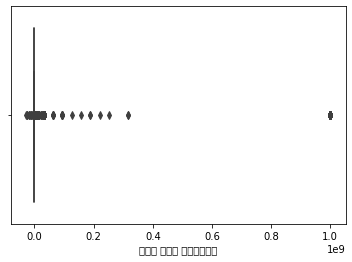

In [19]:
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
sns.boxplot(x=dff['심정지 발생후 병원도착시간'])

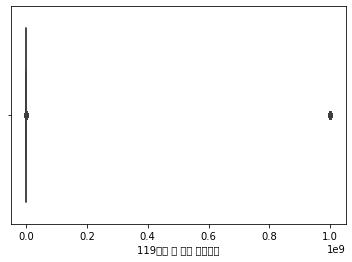

In [20]:
sns.boxplot(x=dff['119신고 후 병원 도착시간'])

In [ ]:
##

In [22]:
d =['연도','환자 거주지 지역의 행정기관코드','병원 소재지 주소의 행정기관코드','급성심장정지 발생 전 마지막 정상일자','급성심장정지 발생 전 마지막 정상시각','병원 도착일자','병원 도착시각','사망일자','사망시각','심장정지 발생일자','심장정지 발생시각','119 신고 일자','119 신고 시각']
dff.drop(d,axis=1,inplace=True)

In [35]:
dff

,성별,연령(만 나이),보험종류,병원 도착 전 심폐소생술 시행 여부,병원 도착 전 자발순환 회복 여부,병원 도착 전 급성심장정지 목격 여부,급성심장정지 환자의 발견자 또는 목격자 유형,일반인 심폐소생술 시행여부,일반인 심폐소생술 시행종류,급성심장정지 발생 장소,급성심장정지 발생 장소(공공장소_세부),급성심장정지 발생 장소(비공공장소_세부),급성심장정지 발생 당시 활동,급성심장정지 발생 원인,급성심장정지 발생 원인(질병 외_세부: 의도성),병원 도착 전 급성심장정지 심전도 소견,병원 도착 전 제세동 실시 여부,과거력_고혈압,과거력_당뇨병,과거력_심장질환,과거력_만성신장질환,과거력_호흡기질환,과거력_뇌졸중,과거력_이상지질혈증,응급실 심폐소생술 시행여부,응급실 ‘심폐소생술 시행하지 않음’ 혹은 ‘20분 이내 중단’ 이유,최초 심전도 확인 장소,응급실 제세동 실시 여부,사망여부,동소재지,정상 목격 여부,심정지 발생후 병원도착시간,119신고 후 병원 도착시간
0,1,63,1,1,2,2,2,2,1.0,2,NaN,1.0,7,2,1.0,40,1,9,9,9,9,9,9,1,3.0,NaN,1,2,1,0,0,1560.0,1560.0
1,1,74,1,1,2,2,2,9,NaN,2,NaN,3.0,99,1,NaN,50,9,9,9,9,9,9,9,9,3.0,NaN,1,1,1,0,0,-84780.0,1380.0
2,2,71,1,1,2,2,9,9,NaN,2,NaN,1.0,7,1,NaN,20,2,9,9,1,9,9,1,9,3.0,NaN,1,2,1,0,0,2220.0,2220.0
3,1,78,1,1,2,1,2,9,NaN,2,NaN,1.0,7,1,NaN,99,9,1,2,9,9,9,9,9,3.0,NaN,3,1,1,0,1,-31980.0,1320.0
4,2,69,2,1,2,9,9,2,1.0,1,1.0,NaN,88,2,1.0,40,9,1,9,9,9,9,9,9,3.0,NaN,1,1,1,1,0,1020.0,960.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87766,2,47,1,1,2,1,2,2,1.0,2,NaN,1.0,99,1,NaN,50,9,9,9,9,9,9,9,9,2.0,1.0,1,1,1,0,1,6540.0,1980.0
87767,1,89,1,1,2,1,9,9,NaN,9,NaN,NaN,99,1,NaN,99,9,9,9,9,9,9,9,9,2.0,1.0,3,1,1,0,1,3840.0,3000.0
87768,2,30,1,1,1,1,2,9,NaN,2,NaN,1.0,88,2,2.0,50,9,2,2,2,2,2,2,2,NaN,NaN,1,1,1,0,1,43320.0,28860.0
87769,1,58,5,1,2,2,2,9,NaN,1,5.0,NaN,7,2,1.0,50,9,1,9,9,9,9,9,9,3.0,NaN,1,1,1,0,0,2400.0,2160.0


#Part 2: 모델링 (Modeling)
검증 방식 설정 및 데이터셋 분할

모델 학습을 위한 파이프라인을 구축 및 학습(fit) 후 테스트셋의 검증 점수를 예측

하이퍼 파라미터 튜닝을 통한 모델 개선

#2_1 검증 방식 설정

In [136]:
## 데이터내의 시계열 데이터가 존재 하지 않다고 판단 되며 크기도 큰거 같지 않아 5-fold cross validation 진행하도록 했다
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV


In [41]:
## 타겟 데이터의 비율은 대략 7:1의 비율로 사망과 생존이 나뉜다.
## 테스트셋의 데이터 크기는 대략 10%정도의 10000으로 하여 검증을 진행 하도록 했다
features = ['성별', '연령(만 나이)', '보험종류', '병원 도착 전 심폐소생술 시행 여부',
       '병원 도착 전 자발순환 회복 여부', '병원 도착 전 급성심장정지 목격 여부',
       '급성심장정지 환자의 발견자 또는 목격자 유형', '일반인 심폐소생술 시행여부', '일반인 심폐소생술 시행종류',
       '급성심장정지 발생 장소', '급성심장정지 발생 장소(공공장소_세부)', '급성심장정지 발생 장소(비공공장소_세부)',
       '급성심장정지 발생 당시 활동', '급성심장정지 발생 원인', '급성심장정지 발생 원인(질병 외_세부: 의도성)',
       '병원 도착 전 급성심장정지 심전도 소견', '병원 도착 전 제세동 실시 여부', '과거력_고혈압', '과거력_당뇨병',
       '과거력_심장질환', '과거력_만성신장질환', '과거력_호흡기질환', '과거력_뇌졸중', '과거력_이상지질혈증',
       '응급실 심폐소생술 시행여부', '응급실 ‘심폐소생술 시행하지 않음’ 혹은 ‘20분 이내 중단’ 이유',
       '최초 심전도 확인 장소', '응급실 제세동 실시 여부', '동소재지', '정상 목격 여부',
       '심정지 발생후 병원도착시간', '119신고 후 병원 도착시간']
target = ['사망여부']
train, test = train_test_split(dff, test_size=10000, random_state=2)
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
print(train.shape, test.shape)

(77771, 33) (10000, 33)


In [85]:
## 기준모델을 설정하고 기준 모델의 f1 score를 뽑아본다.
## 기준모델은 로지스틱 회귀 분류 모델을 사용.
## PCA 사용.
## 결측치는 0 으로.
## GridSearchCV를 이용하여 PCA 최적값과 logistic__C 값을 구해서 사용한다
pca = PCA()
logistic = LogisticRegression()
Imputer = SimpleImputer(strategy='constant')
base = Pipeline(steps=[('Imputer',Imputer),("pca", pca), ("logistic", logistic)])

param_grid = {
    "pca__n_components": [5, 15, 30, 45, 64],
    "logistic__C": np.logspace(-4, 4, 4),
}
search = GridSearchCV(base, param_grid, n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


Best parameter (CV score=0.310):
{'logistic__C': 0.0001, 'pca__n_components': 5}


In [114]:
## 스킷런 LogisticRegressionCV를 이용하여 디폴트 값인 k-5를 사용하여 cv를 진행한다.
pca = PCA(n_components=5)
logistic = LogisticRegressionCV(cv=5)
Imputer = SimpleImputer(strategy='constant')
base = Pipeline(steps=[('Imputer',Imputer),("pca", pca), ("logistic", logistic)])
base.fit(X_train,y_train)
a=base.predict(X_test)
print('테스트세트 정확도',accuracy_score(a,y_test))
print('f1스코어',f1_score(y_test, a))
print(classification_report(y_test, a))

테스트세트 정확도 0.3107
f1스코어 0.36405572469785036
              precision    recall  f1-score   support

           0       0.14      0.91      0.25      1249
           1       0.94      0.23      0.36      8751

    accuracy                           0.31     10000
   macro avg       0.54      0.57      0.31     10000
weighted avg       0.84      0.31      0.35     10000



In [108]:
## 정확도와 f1스코어가 너무 낮게 나와 PCA를 진행하지 않고 단순 로지스틱으로 구해보았다.
## PCA를 진행하지 않을시 생존 데이터를 맞추는 시도를 하지 않는것을 알게 되었다.
## 로지스틱 모델이 데이터셋에 좋은 결과를 내지 못하고 있음을 알 수 있게 되었다.
logistic = LogisticRegressionCV()
Imputer = SimpleImputer(strategy='constant')
base = Pipeline(steps=[('Imputer',Imputer), ("logistic", logistic)])
base.fit(X_train,y_train)
a=base.predict(X_test)
print('테스트세트 정확도',accuracy_score(a,y_test))
print('f1스코어',f1_score(y_test, a))
print(classification_report(y_test, a))

테스트세트 정확도 0.8338
f1스코어 0.9085506767910201
              precision    recall  f1-score   support

           0       0.14      0.07      0.09      1249
           1       0.88      0.94      0.91      8751

    accuracy                           0.83     10000
   macro avg       0.51      0.50      0.50     10000
weighted avg       0.78      0.83      0.81     10000



In [112]:
## 피쳐를 단순 2가지로만 했더니 모든 데이터 예측을 아예 사망으로 처리하는 결과가 나오게 되었다.
## 결과적으로 로지스틱 기준 모델의 경우 정확도와 f1스코어는 상당히 낮은것으로 판단이 된다.
logistic.fit(X_train[['연령(만 나이)','성별']], y_train)
pred = logistic.predict(X_test[['연령(만 나이)','성별']])
print('테스트세트 정확도', logistic.score(X_test[['연령(만 나이)','성별']], y_test))
print(f1_score(y_test, pred))
print(classification_report(y_test, pred))

테스트세트 정확도 0.8751
0.93339021918831
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1249
           1       0.88      1.00      0.93      8751

    accuracy                           0.88     10000
   macro avg       0.44      0.50      0.47     10000
weighted avg       0.77      0.88      0.82     10000



#2_2 모델 학습을 위한 파이프라인을 구축 후 학습(fit)

In [113]:
##본래 사용하기로 하였던 트리기반 모델인 XGB사용
##초모수 설정및 CV 전 간단한 XGB 파이프라인을 만든 후 학습 및 테스트셋 검증을 진행한다.
##초모수 설정을 하지않은 XGB 모델의 경우 0.91의 정확도와 생존데이터 예측의 경우 0.55 사망 데이터의 예측의 경우 0.95의 f1 score를 보여주고 있었다
##현재 생존시 데이터셋의 recall 값이 낮으므로 recall 값을 올리는 방향으로 설정을 진행 하도록 한다.
import xgboost as xgb
xgb_model = xgb.XGBClassifier(silent=False, 
                              booster='gbtree',
                              scale_pos_weight=1,
                              learning_rate=0.01,  
                              colsample_bytree = 0.4,
                              subsample = 0.8,
                              objective='binary:logistic', 
                              n_estimators=100, 
                              max_depth=4, 
                              gamma=10, 
                              seed=777)
Imputer = SimpleImputer(strategy='constant')
simple_xgb = Pipeline(steps=[('Imputer',Imputer), ("xgb_model", xgb_model)])
y_pred = simple_xgb.fit(X_train, y_train).predict(X_test)
print('테스트세트 정확도',accuracy_score(y_pred,y_test))
print('f1_score',f1_score(y_pred,y_test))
print(classification_report(y_test, y_pred))

테스트세트 정확도 0.9155
f1_score 0.9533793103448277
              precision    recall  f1-score   support

           0       0.82      0.41      0.55      1249
           1       0.92      0.99      0.95      8751

    accuracy                           0.92     10000
   macro avg       0.87      0.70      0.75     10000
weighted avg       0.91      0.92      0.90     10000



In [185]:
##roc_auc 스코어의 경우 0.7이 나왔다
roc_auc_score(y_test, y_pred)

0.6998227996178226

Text(111.5, 0.5, 'Actual')

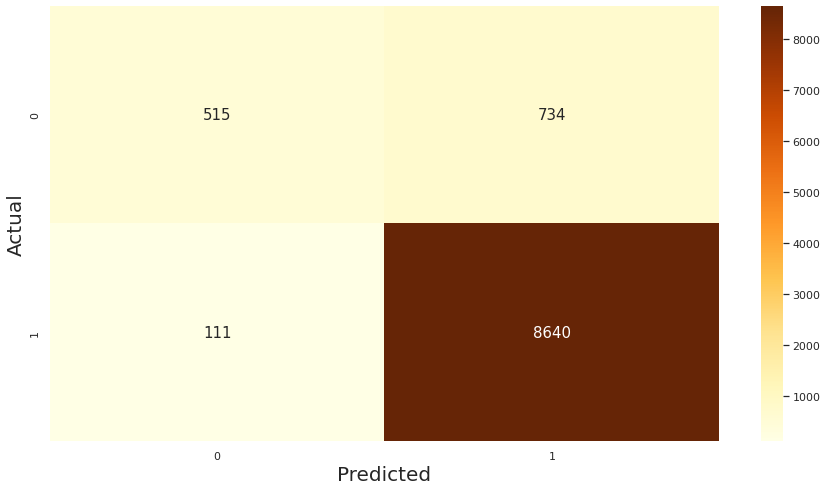

In [134]:
cm = confusion_matrix(y_test, y_pred)
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(cm, annot=True, annot_kws={"size": 15},fmt='d', cmap='YlOrBr')
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)


#2_3 하이퍼 파라미터 튜닝을 통한 모델 개선

XGBoost와 관련된 Hypter Parameter는 다음 세가지 범주로 나뉜다. XGBoost가 의사결정나무에 기반하기 때문에 관련된 모수와 기계학습과 관련이 있기 때문에 이와 연관된 다수 초모수가 포함된다.

---

학습 초모수


objective [기본설정값=reg:linear]: 지도학습 손실 최소화 함수를 정의

binary:logistic: 이항 분류 문제 로직스틱 회귀모형으로 반환값이 클래스가 아니라 예측 확률.

multi:softmax: 다항 분류 문제의 경우 소프트맥스(Softmax)를 사용해서 분류하는데 반횐되는 값이 예측확률이 아니라 클래스임. 또한 num_class도 지정해야함.

multi:softprob: 각 클래스 범주에 속하는 예측확률을 반환함.

eval_metric: 설정한 objective별로 기본설정값이 지정되어 있음.

rmse: root mean square error

mae: mean absolute error

logloss: negative log-likelihood

error: Binary classification error rate (0.5 threshold)

merror: Multiclass classification error rate

mlogloss: Multiclass logloss

auc: Area under the curve

seed [기본설정값: 0]: 재현가능하도록 난수를 고정시킴.


---


일반 초모수

booster: 의사결정 기반 모형(gbtree), 선형 모형(linear)

mthread: 병렬처리에 사용되는 코어수, 특정값을 지정하지 않는 경우 자동으로
 시스템 코어수를 탐지하여 병렬처리에 동원함.


---


부스팅 초모수

eta [기본설정값: 0.3]: GBM에 학습율과 유사하고 일반적으로 0.01 ~ 0.2 값이 사용됨
min_child_weight [기본설정값: 1]: 과적합(overfitting)을 방지할 목적으로 사용되는데, 너무 높은 값은 과소적합(underfitting)을 야기하기 때문에 CV를 사용해서 적절한 값이 제시되어야 한다.

max_depth [기본설정값: 6]: 과적합 방지를 위해서 사용되는데 역시 CV를 사용해서 적절한 값이 제시되어야 하고 보통 3-10 사이 값이 적용된다.

max_leaf_nodes: max_leaf_nodes 값이 설정되면 max_depth는 무시된다. 따라서 두값 중 하나를 사용한다.

max_delta_step [기본설정값: 0]: 일반적으로 잘 사용되지 않음.

subsample [기본설정값: 1]: 개별 의사결정나무 모형에 사용되는 임의 표본수를 지정. 보통 0.5 ~ 1 사용됨.

colsample_bytree [기본설정값: 1]: 개별 의사결정나무 모형에 사용될 변수갯수를 지정. 보통 0.5 ~ 1 사용됨.

colsample_bylevel [기본설정값: 1]: subsample, colsample_bytree 두 초모수 설정을 통해서 이미 의사결정나무 모형 개발에 사용될 변수갯수와 관측점 갯수를 사용했는데 추가로 colsample_bylevel을 지정하는 것이 특별한 의미를 갖는지 의문이 듦.

lambda [기본설정값: 1]: 능선 회쉬(Ridge Regression)의 L2 정규화(regularization) 초모수. 그다지 많이 사용되고 있지는 않음.

alpha [기본설정값: 0]: 라쏘 회귀(Lasso Regression)의 L1 정규화(regularization) 초모수로 차원이 높은 경우 알고리즘 속도를 높일 수 있음.

scale_pos_weight [기본설정값: 1]: 클래스 불균형이 심한 경우 0보다 큰 값을 지정하여 효과를 볼 수 있음.

---


참고문헌: Analytics Vidhya, "Complete Guide to Parameter Tuning in XGBoost with codes in Python"

In [119]:
xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=10,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=777,
              silent=False, subsample=0.8, verbosity=1)

In [152]:
np.linspace(0.02, 0.2, 10)

array([0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ])

In [154]:
##randomCV를 사용하여 최적화를 진행하여본다.
##과적합 방지를 위하여 max depth 설정 최적값을 2~9 사이 정수 값으로 지정한다.
## 트리 모형의 임의 표본수를 0.4~1까지 7분할 하여 지정.
## 학습율의 경우 0.01~0.2사이의 10개의 값을 지정하여 최적화를 진행한다.
## 스코어링 단위는 각 클래스에 속하는 표본의 갯수로 가중평균을 구한 f1_weighted 값을 사용한다.
xgb_clf = xgb.XGBClassifier()
Imputer = SimpleImputer(strategy='constant')
Hyper_xgb = Pipeline(steps=[('Imputer',Imputer), ("xgb_model", xgb_clf)])
params = {'xgb_model__max_depth': list(range(2,10)),
          'xgb_model__subsample': np.linspace(0.4, 1, 7),
          'xgb_model__learning_rate' : np.linspace(0.02, 0.2, 10)
        }
random_search = RandomizedSearchCV(Hyper_xgb, param_distributions=params, n_iter=100,
                                   scoring='f1_weighted', n_jobs=4, verbose=3, random_state=1001 )
random_search.fit(X_train,y_train)
y_predr=random_search.predict(X_test)
print(random_search.best_params_)
print(random_search.score(X_test,y_test))
print(classification_report(y_predr,y_test))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 20.9min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed: 50.7min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed: 89.7min finished


{'xgb_model__subsample': 1.0, 'xgb_model__max_depth': 5, 'xgb_model__learning_rate': 0.12000000000000002}
0.9045755647630868
              precision    recall  f1-score   support

           0       0.43      0.81      0.56       662
           1       0.99      0.92      0.95      9338

    accuracy                           0.92     10000
   macro avg       0.71      0.87      0.76     10000
weighted avg       0.95      0.92      0.93     10000



In [184]:
#roc_auc 스코어는 0.7이 나오게되었다
roc_auc_score(y_test, y_predr)

0.7073724800889735

Text(111.5, 0.5, 'Actual')

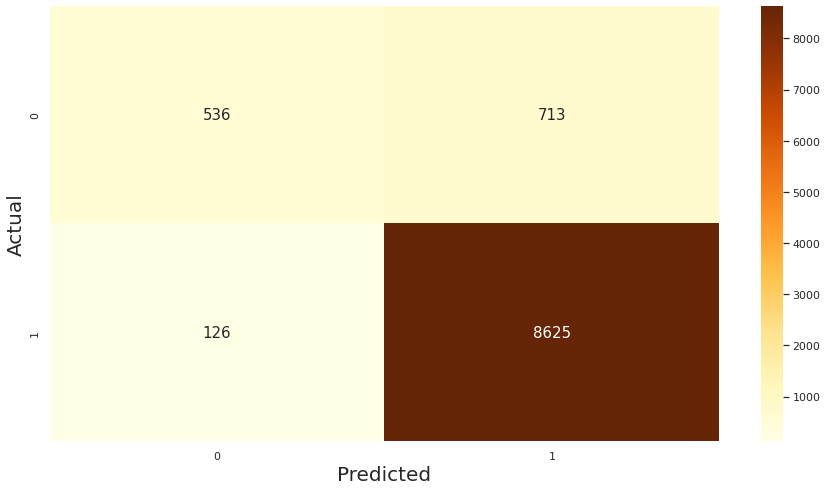

In [155]:
##하이퍼 파라메터 튜닝을 끝내니 f1스코어가 조금 좋아졌다.
cm = confusion_matrix(y_test, y_predr)
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(cm, annot=True, annot_kws={"size": 15},fmt='d', cmap='YlOrBr')
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)

In [156]:
random_search.best_params_

{'xgb_model__learning_rate': 0.12000000000000002,
 'xgb_model__max_depth': 5,
 'xgb_model__subsample': 1.0}

In [157]:
##교차검증을 실행하여 모델의 과적합을 방지하도록 한다.
hr_dmatrix = xgb.DMatrix(data=dff[features], label=dff[target])

hr_cv = xgb.cv(dtrain=hr_dmatrix, 
               params=random_search.best_params_, 
               nfold=5, 
               num_boost_round=10, 
               metrics="auc", 
               as_pandas=True)

hr_cv

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.886613,0.000780,0.882223,0.003255
1,0.892756,0.000951,0.888402,0.003168
2,0.896305,0.000725,0.891144,0.003275
3,0.898418,0.000888,0.892813,0.002962
4,0.900192,0.000594,0.893736,0.002649
5,0.901529,0.000421,0.894911,0.002748
6,0.903120,0.000688,0.895841,0.002386
7,0.904446,0.000605,0.896456,0.002207
8,0.905578,0.000771,0.896960,0.002239
9,0.906785,0.000858,0.897342,0.002209


In [158]:
##ROC 커브를 이용하여 optimal_threshold 값을 구하여 사용하도록한다.
random_search.predict_proba(X_test)

array([[9.0748310e-02, 9.0925169e-01],
       [3.1352621e-01, 6.8647379e-01],
       [4.8094213e-02, 9.5190579e-01],
       ...,
       [9.0031087e-01, 9.9689119e-02],
       [3.6741072e-01, 6.3258928e-01],
       [6.9618225e-05, 9.9993038e-01]], dtype=float32)

In [176]:
##생존으로 판단할 확률
y_pred_proba = random_search.predict_proba(X_test)[:, 1]
y_pred_proba

array([0.9092517 , 0.6864738 , 0.9519058 , ..., 0.09968912, 0.6325893 ,
       0.9999304 ], dtype=float32)

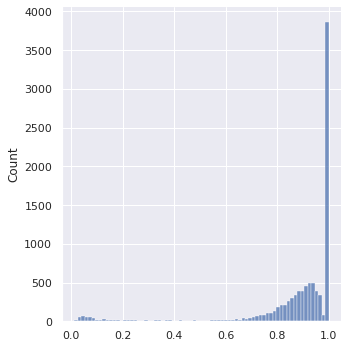

In [177]:
##생존으로 판단할 확률이 상당히 낮음을 알 수있다.
sns.displot(y_pred_proba);

In [178]:
from sklearn.metrics import roc_curve

# roc_curve(타겟값, prob of 1)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
roc

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,1.999968
1,0.000000,0.000114,0.999968
2,0.000000,0.000800,0.999964
3,0.000000,0.001028,0.999964
4,0.000000,0.001143,0.999964
...,...,...,...
1594,0.955965,0.999771,0.036596
1595,0.955965,0.999886,0.036596
1596,0.963971,0.999886,0.033523
1597,0.963971,1.000000,0.033454


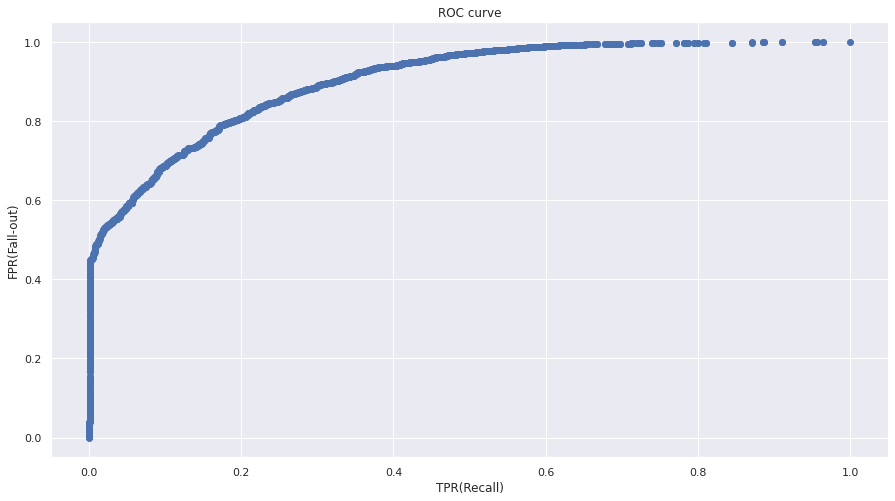

In [179]:
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.ylabel('FPR(Fall-out)')
plt.xlabel('TPR(Recall)');

In [180]:
# threshold 최대값의 인덱스, np.argmax()
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_threshold)

idx: 683 , threshold: 0.8686104


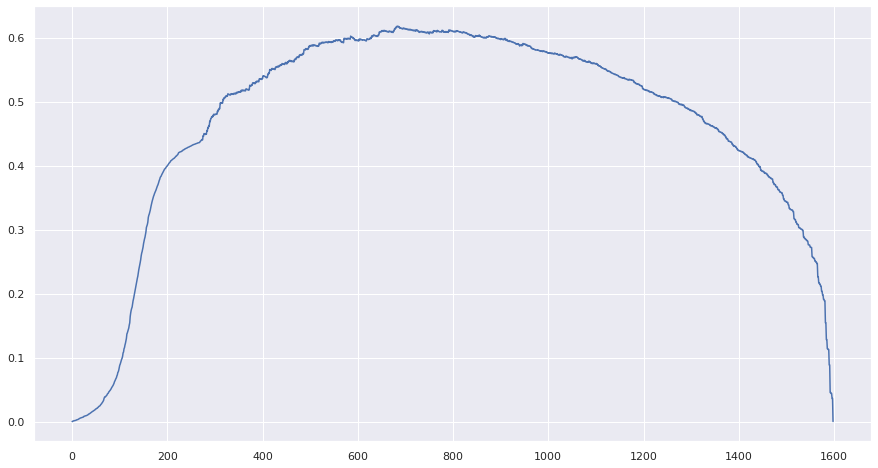

In [181]:
plt.plot(tpr-fpr);

In [182]:
y_pred_optimal = y_pred_proba >= optimal_threshold
print(classification_report(y_test, y_pred_optimal))

              precision    recall  f1-score   support

           0       0.36      0.83      0.50      1249
           1       0.97      0.79      0.87      8751

    accuracy                           0.80     10000
   macro avg       0.67      0.81      0.69     10000
weighted avg       0.89      0.80      0.83     10000



In [183]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_test, y_pred_proba)
auc_score

0.903198481536915

#Part 3: 시각화 (Visualization)
모델의 해석을 위한 시각화를 진행한다.

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


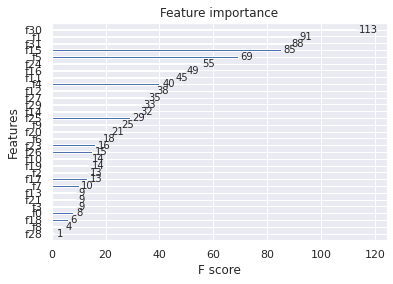

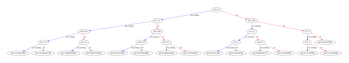

In [186]:
## graphviz 라이브러리를 이용하여 트리 시각화를 진행하여 특성 중요도를 파악해본다.
%matplotlib inline 
plt.rc('font', family='NanumGothic') # 한글 폰트깨짐 해결(맥) 윈도우는 NanumGothic
import graphviz
from sklearn.tree import export_graphviz
xgb.plot_importance(xgb_model)
xgb.plot_tree(xgb_model, num_trees=3)

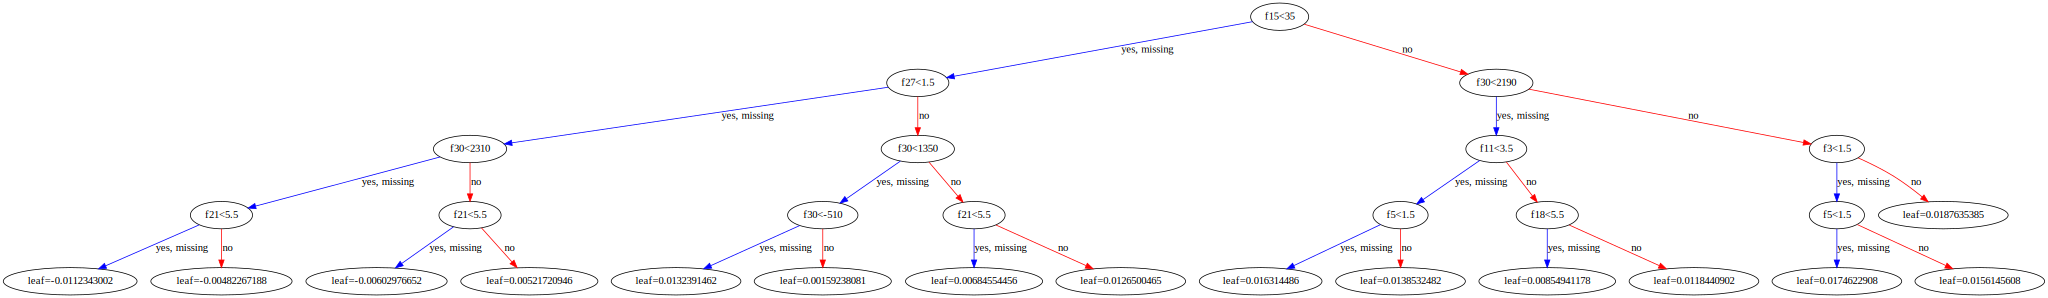

In [187]:
xgb.to_graphviz(xgb_model, num_trees=3)

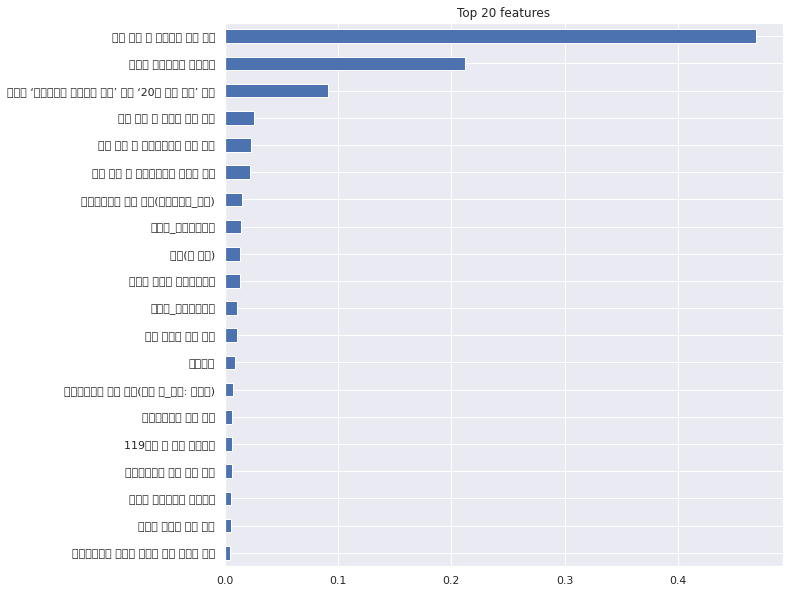

In [197]:
##Feature Importances(Mean decrease impurity, MDI)
##각각 특성을 모든 트리에 대해 평균불순도감소(mean decrease impurity)를 계산한 값입니다.

# 특성 중요도
Hyper_xgb.fit(X_train,y_train)
rf = Hyper_xgb.named_steps['xgb_model']
importances = pd.Series(rf.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic') # 한글 폰트깨짐 해결(맥) 윈도우는 NanumGothi
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

In [198]:
## 순열중요도 (Permutation Importance, Mean Decrease Accuracy,MDA)
##중요도 측정은 관심있는 특성에만 무작위로 노이즈를 주고 예측을 하였을 때 성능 평가지표(정확도, F1, $R^2$ 등)가 얼마나 감소하는지를 측정합니다.
##eli5 라이브러리를 이용하여 순열중요도를 계산.

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    Hyper_xgb.named_steps['xgb_model'], # model
    scoring='f1', # f1사용
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_val_transformed = Hyper_xgb.named_steps['Imputer'].transform(X_test)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val_transformed, y_test);


In [200]:
##특성별 스코어 순서
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0306 ± 0.0027,병원 도착 전 자발순환 회복 여부
0.0072 ± 0.0009,응급실 ‘심폐소생술 시행하지 않음’ 혹은 ‘20분 이내 중단’ 이유
0.0005 ± 0.0002,119신고 후 병원 도착시간
0.0004 ± 0.0002,연령(만 나이)
0.0001 ± 0.0002,동소재지
0.0001 ± 0.0002,급성심장정지 발생 당시 활동
0.0001 ± 0.0001,급성심장정지 발생 장소(공공장소_세부)
0.0001 ± 0.0001,최초 심전도 확인 장소
0.0001 ± 0.0003,병원 도착 전 급성심장정지 심전도 소견
0.0000 ± 0.0002,과거력_고혈압


In [ ]:
##SHAP를 이용하여 

#Part 4: Self FeedBack

시계열 데이터 관련 지식이 모자라서 심정지 날짜와 시간 데이터를 사용하지 않았지만

날짜와 시간데이터를 사용하여서 분석을 진행하였으면 더 좋은 결과가 나오지 않았을까 한다.

또한 날짜 데이터가 존재 하므로 심정지 발생 날짜의 기온데이터를 크롤링 후 추가하여 분석에 이용 해보았으면 어땟을까 하는 생각이 든다.